In [1]:
import numpy as np
import pandas as pd
#import seaborn as sns
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.models import  Model
from sklearn.utils import resample
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#from google.colab import drive
import time

np.random.seed(100)

In [2]:
train_dir = 'E:/dataset/FER2013+CK+KFE/train/'
val_dir = 'E:/dataset/FER2013/val/'

BS = 64
PATIENCE =10

IMAGE_SIZE = (96,96)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
print(IMAGE_SHAPE)

classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

(96, 96, 3)


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    zoom_range=0.3,
                                    shear_range=0.3,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=False
                                    
                                    )

val_datagen  = ImageDataGenerator(rescale = 1./255
                                   
                                  )

In [4]:
# Load datasat

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = IMAGE_SIZE,
                                                   class_mode = 'categorical',
                                                   batch_size = BS)
#test_dir = 'N:/내 드라이브/DataSet/FER2013/test/'
val_dataset = val_datagen.flow_from_directory(directory = val_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  #shuffle =True,
                                                  batch_size = BS)

Found 31935 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [5]:
from IPython.display import Image, HTML
# Total train/test sample

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
val_count = count_exp(val_dir, 'val')

HTML(train_count.append(val_count).to_html(escape=False))

,Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise
train,4376,796,4416,7634,5936,5201,3576
val,467,56,496,895,607,653,415


In [6]:
# Data labels

class_labels = val_dataset.class_indices
class_labels

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

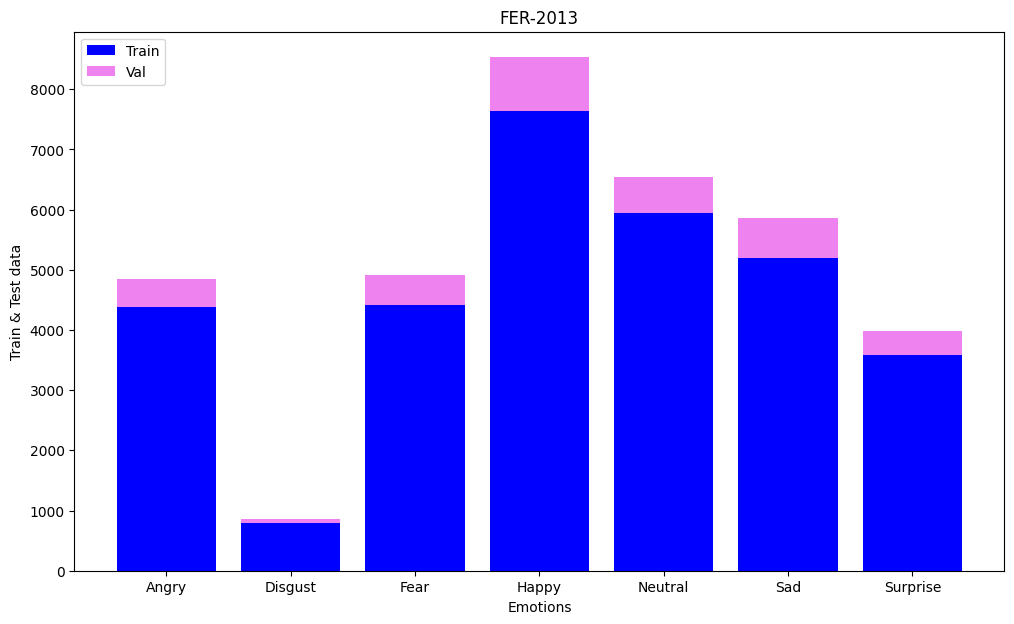

In [7]:
# # lot distribution of train/test dataste per class

x = list(val_count.columns)
y1 =train_count.iloc[0].to_list()
y2 = val_count.iloc[0].to_list()
plt.figure(figsize=(12,7))

plt.bar(x, y1, color='blue')
plt.bar(x, y2, bottom=y1, color='violet')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Val"], loc='upper left')
plt.title("FER-2013")
plt.savefig('distribution.png')
plt.show()

In [8]:
from collections import Counter
counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  
class_weights

{0: 1.74, 1: 9.59, 2: 1.73, 3: 1.0, 4: 1.29, 5: 1.47, 6: 2.13}

In [9]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam

base_model = tf.keras.applications.xception.Xception(input_shape=IMAGE_SHAPE, include_top=False, weights="imagenet")
base_model.summary()



Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 47, 47, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 47, 47, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 47, 47, 32)   0           ['block1_conv1_bn[0][0]'] 

                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 12, 12, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 12, 12, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)                                                                                        
                                                                                                  
 conv2d_2 (Conv2D)              (None, 6, 6, 728)    186368      ['add_1[0][0]']                  
                                                                                                  
 block4_pool (MaxPooling2D)     (None, 6, 6, 728)    0           ['block4_sepconv2_bn[0][0]']     
          

 block7_sepconv1_bn (BatchNorma  (None, 6, 6, 728)   2912        ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 6, 6, 728)   0           ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block7_sepconv2 (SeparableConv  (None, 6, 6, 728)   536536      ['block7_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv2_bn (BatchNorma  (None, 6, 6, 728)   2912        ['block7_sepconv2[0][0]']        
 lization)

                                                                                                  
 block10_sepconv1_act (Activati  (None, 6, 6, 728)   0           ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 6, 6, 728)   536536      ['block10_sepconv1_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block10_sepconv1_bn (BatchNorm  (None, 6, 6, 728)   2912        ['block10_sepconv1[0][0]']       
 alization)                                                                                       
                                                                                                  
 block10_s

 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 6, 6, 728)   2912        ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (Add)                   (None, 6, 6, 728)    0           ['block12_sepconv3_bn[0][0]',    
                                                                  'add_9[0][0]']                  
                                                                                                  
 block13_sepconv1_act (Activati  (None, 6, 6, 728)   0           ['add_10[0][0]']                 
 on)                                                                                              
          

In [10]:
for layer in base_model.layers:
    layer.trainable=True

In [11]:
model = models.Sequential()
model.add(base_model)
#model.add(layers.Conv2D(1280, (1, 1), (1, 1), 'same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
#model.add(BatchNormalization())
#model.add(Dropout(0.3))
#model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 2048)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K

def callbackFunction(modelName):
  checkpoint = ModelCheckpoint(f"Checkpoints/{modelName}.h5", monitor = "val_accuracy", save_best_only = True, mode = "auto", verbose = 1)
  early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)
  callbacks = [early_stopping, checkpoint]
  return callbacks

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [13]:
METRICS = [
      tf.keras.metrics.Accuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score
]

model.compile(
    optimizer=Adam(learning_rate=0.00001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']#, f1_score]
     #metrics=METRICS        
)

In [14]:
with tf.device('/GPU:0'):
    history = model.fit(train_dataset, validation_data=val_dataset,  
                      callbacks=callbackFunction('2-2_X'),
                      batch_size=BS,  
                      epochs = 30, 
                      verbose=1,
                      class_weight = class_weights
                      )

Epoch 1/30
499/499 [==============================] - ETA: 0s - loss: 3.2929 - accuracy: 0.1853
Epoch 1: val_accuracy improved from -inf to 0.21733, saving model to Checkpoints\2-2_X.h5
499/499 [==============================] - 79s 149ms/step - loss: 3.2929 - accuracy: 0.1853 - val_loss: 1.9275 - val_accuracy: 0.2173
Epoch 2/30
499/499 [==============================] - ETA: 0s - loss: 3.1572 - accuracy: 0.2234
Epoch 2: val_accuracy improved from 0.21733 to 0.30872, saving model to Checkpoints\2-2_X.h5
499/499 [==============================] - 63s 125ms/step - loss: 3.1572 - accuracy: 0.2234 - val_loss: 1.8039 - val_accuracy: 0.3087
Epoch 3/30
499/499 [==============================] - ETA: 0s - loss: 2.9914 - accuracy: 0.2919
Epoch 3: val_accuracy improved from 0.30872 to 0.38674, saving model to Checkpoints\2-2_X.h5
499/499 [==============================] - 63s 126ms/step - loss: 2.9914 - accuracy: 0.2919 - val_loss: 1.6424 - val_accuracy: 0.3867
Epoch 4/30
499/499 [==============

499/499 [==============================] - 65s 129ms/step - loss: 1.8344 - accuracy: 0.5698 - val_loss: 1.0683 - val_accuracy: 0.6108
Epoch 27/30
499/499 [==============================] - ETA: 0s - loss: 1.8195 - accuracy: 0.5761
Epoch 27: val_accuracy improved from 0.61076 to 0.61298, saving model to Checkpoints\2-2_X.h5
499/499 [==============================] - 65s 130ms/step - loss: 1.8195 - accuracy: 0.5761 - val_loss: 1.0595 - val_accuracy: 0.6130
Epoch 28/30
499/499 [==============================] - ETA: 0s - loss: 1.7923 - accuracy: 0.5787
Epoch 28: val_accuracy improved from 0.61298 to 0.61716, saving model to Checkpoints\2-2_X.h5
499/499 [==============================] - 65s 130ms/step - loss: 1.7923 - accuracy: 0.5787 - val_loss: 1.0496 - val_accuracy: 0.6172
Epoch 29/30
499/499 [==============================] - ETA: 0s - loss: 1.7774 - accuracy: 0.5850
Epoch 29: val_accuracy did not improve from 0.61716
499/499 [==============================] - 64s 128ms/step - loss: 1

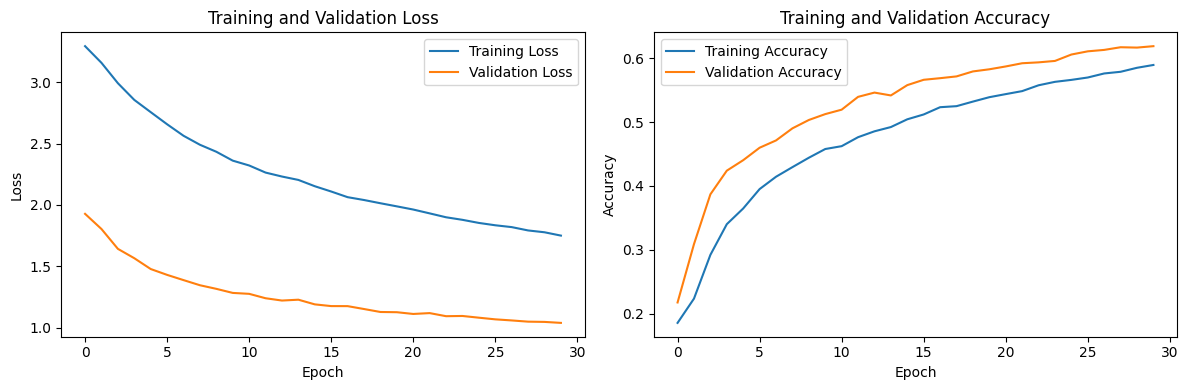

In [15]:
import matplotlib.pyplot as plt

# Extract training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
model.save('new_2-3_X.h5')

In [17]:
#  Som Scores of train & test set

train_evalation = model.evaluate(train_dataset)
val_evaluation = model.evaluate(val_dataset)
#test_evaluation2 = model.evaluate(test_dataset2)

57/57 [==============================] - 2s 29ms/step - loss: 1.0395 - accuracy: 0.6188


In [18]:
metric_list = ["Loss","Accuracy", "Precision", "F1_Score", "Recall", "Auc"]

df = pd.DataFrame(list(zip(metric_list, 
                           [round(num, 3) for num in train_evalation], 
                           [round(num, 3) for num in val_evaluation])),
                  columns=['Metric Name', 'Train', 'Validate'])

print('\n\nModel Scores\n')

HTML(df.to_html(escape=False))



Model Scores



,Metric Name,Train,Validate
0,Loss,1.030,1.040
1,Accuracy,0.611,0.619


In [19]:
test_dir = 'E:/dataset/Only_Kor_Test/'
test_datagen  = ImageDataGenerator(rescale = 1./255)
test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  #shuffle =True,
                                                  batch_size = BS)
jaffe_dir = 'E:/dataset/jaffedbase/'
jaffe_datagen  = ImageDataGenerator(rescale = 1./255)
jaffe_dataset = test_datagen.flow_from_directory(directory = jaffe_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  #shuffle =True,
                                                  batch_size = BS)

Found 758 images belonging to 7 classes.
Found 213 images belonging to 7 classes.


In [20]:
test_evaluation = model.evaluate(test_dataset)
jaffe_evaluation = model.evaluate(jaffe_dataset)

4/4 [==============================] - 1s 260ms/step - loss: 1.7504 - accuracy: 0.3146


In [21]:
metric_list = ["Loss","Accuracy", "Precision", "F1_Score", "Recall", "Auc"]

df = pd.DataFrame(list(zip(metric_list, 
                           [round(num, 3) for num in train_evalation], 
                           [round(num, 3) for num in val_evaluation],
                           [round(num, 3) for num in test_evaluation],
                           [round(num, 3) for num in jaffe_evaluation],
                          )),
                  columns=['Metric Name', 'Train', 'Validate', 'KFE', 'JAFFE'])

print('\n\nModel Scores\n')

HTML(df.to_html(escape=False))



Model Scores



,Metric Name,Train,Validate,KFE,JAFFE
0,Loss,1.030,1.040,1.971,1.750
1,Accuracy,0.611,0.619,0.328,0.315
